In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x


In [2]:
# mean shifted Gaussians
N = 1000
np.random.seed(0)
X = np.random.randn(N)
Y = np.random.randn(N) + 0.2
np.savez("simple.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))


The following function takes generates two samples, one of a normal distribution and one from a laplace distribution. The laplace function uses the parameter b to regulate how far it spreads on the x axis, which obviously affects its variance. b is chosen specifically so that the normal distribution and the laplace distribution have the same variance. The variance for a Laplace distribution can be calculated with the formula 2b² => 2*np.sqrt(0.5)² = 2*0.5 = 1 = sigma² of the normal distribution


In [3]:
# gaussian vs laplace with same mean / variance
from scipy.stats import laplace, norm, poisson

def sample_gaussian_vs_laplace(n=220, mu=0.0, sigma2=1, b=np.sqrt(0.5)):    
    # sample from both distributions
    X=norm.rvs(size=n)*np.sqrt(sigma2)+mu
    Y=laplace.rvs(size=n, loc=mu, scale=b)
    
    return X,Y

np.random.seed(2)
N=300
X, Y = sample_gaussian_vs_laplace(n=N)
np.savez("almost_simple.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

In [4]:
def sample_blobs(n, ratio, rows=5, cols=5, sep=10, rs=None):
    # ratio is eigenvalue ratio
    correlation = (ratio - 1) / (ratio + 1)

    # generate within-blob variation
    mu = np.zeros(2)
    sigma = np.eye(2)
    X = np.random.multivariate_normal(mu, sigma, size=n)

    corr_sigma = np.array([[1, correlation], [correlation, 1]])
    Y = np.random.multivariate_normal(mu, corr_sigma, size=n)

    # assign to blobs
    X[:, 0] += np.random.randint(rows, size=n) * sep
    X[:, 1] += np.random.randint(cols, size=n) * sep
    Y[:, 0] += np.random.randint(rows, size=n) * sep
    Y[:, 1] += np.random.randint(cols, size=n) * sep

    return X, Y

np.random.seed(0)
N=500
ratio = 0.01
rows_cols = 10
X, Y = sample_blobs(n=N, rows=rows_cols, cols=rows_cols, ratio=ratio)
np.savez("blobs.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))
X, Y = sample_blobs(n=N, rows=rows_cols, cols=rows_cols, ratio=ratio)
np.savez("blobs2.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))
X, Y = sample_blobs(n=N, rows=1, cols=1, ratio=ratio)
np.savez("blobs_zoomed.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

In [5]:
np.random.seed(0)
N=400
X = np.random.randn(N)
Y = np.random.randn(N)
np.savez("hsic1.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))


In [6]:
def sample_hsic(n, angle, sigma=0.2, offset=1):
    n4 = int(n/4)
    N = np.random.randn(n4, 2)*sigma
    S = np.random.randn(n4, 2)*sigma
    E = np.random.randn(n4, 2)*sigma
    W = np.random.randn(n4, 2)*sigma
    
    N[:,1] += offset
    S[:,1] -= offset
    W[:,0] -= offset
    E[:,0] += offset
    
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    A = R.dot(np.vstack((N,S,W,E)).T).T
    
    return A[:,0], A[:,1]

N=200
np.random.seed(0)
X,Y = sample_hsic(n=N, angle=np.pi/12)
np.savez("hsic2.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

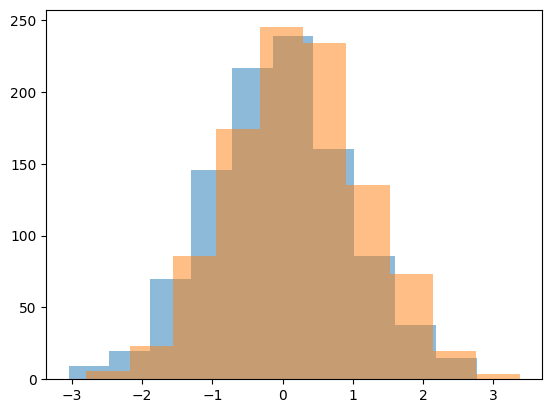

In [7]:
data = np.load("simple.npz")
X = data["X"]
Y = data["Y"]
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5);

In [8]:
def simple_statistic(X,Y, squared=False):
    assert X.ndim == Y.ndim == 1
    
    # IMPLEMENT: compute mean difference of X and Y
    result = np.mean(X) - np.mean(Y)
    
    if squared:
        result *= result
    return result

my_statistic = simple_statistic(X,Y)
print("Mean differencce:", my_statistic)

Mean differencce: -0.25887364


We now compare the means of the two distributions. This is a step we do to test wether they are the same. The basic idea is to look at what the the mean of the joint distribution would be and then compare that to the mean of each of the single distributions. 

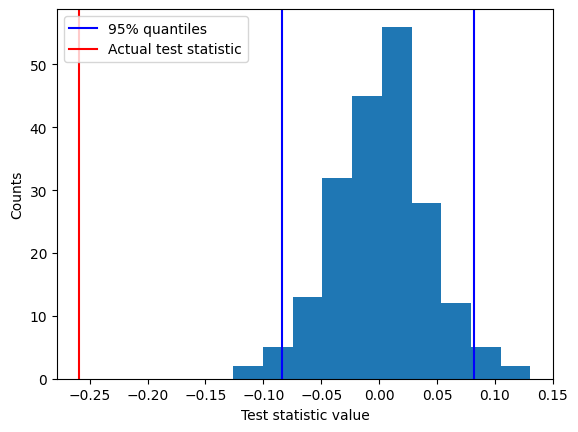

In [9]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim
    
    statistics = np.zeros(num_permutations)
    
    range_ = range(num_permutations)
    if prog_bar:
        range_ = tqdm(range_)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))
            
        # IMPLEMENT: permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics

num_permutations = 200
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

def plot_permutation_samples(null_samples, statistic=None):
    plt.hist(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    
plot_permutation_samples(statistics, my_statistic)

What I do not understand here is that the text states that the blue distribution was achieved by this recipe: "For that, we can merge the samples and shuffle them, after which they have the same "joint" distribution. We can then re-compute the statistic for multiple permutations to get a feeling for how the statistic is distributed." . Shouldn't this always result in the same distribution? What is the red line? it's a distribution, right? The blue histogramm basically just shows how far off the "mean" of 95% of the randomly generated "joint" distribution falls, but doesn't the mean always fall to the mean? 

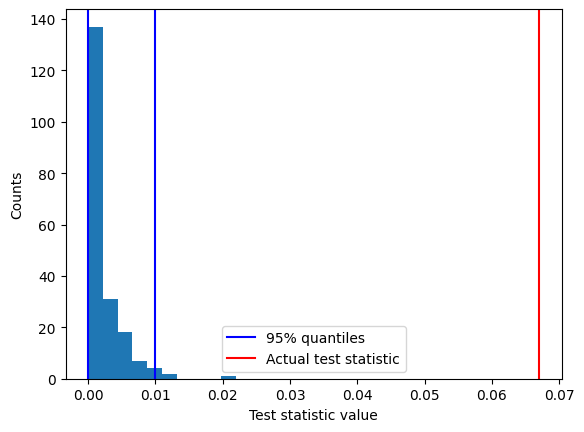

In [10]:
# IMPLEMENT: use squared test statistic
simple_statistic_squared = lambda X,Y: simple_statistic(X,Y,squared=True)

# visualise test
statistics = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y)
plot_permutation_samples(statistics, my_statistic)

In [11]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left side
    Y - 2d array, samples on right side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

In [12]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

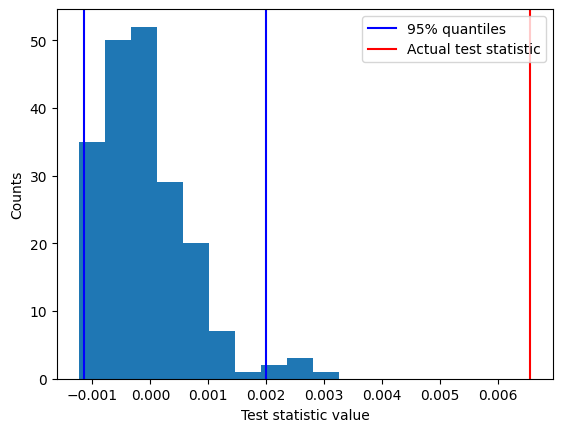

In [13]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

Without really understanding the mathematics of MMD, here are the mmd results for N(1,100) and N(2,4)

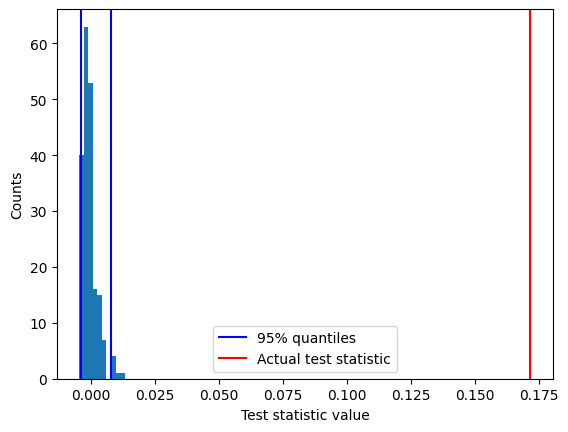

In [14]:
def sample_gaussian_vs_poisson(n=220, mu_1=0.0, sigma2_1=1, lamb=1):    
    # sample from both distributions
    X=norm.rvs(size=n)*np.sqrt(sigma2_1)+mu_1
    Y=poisson.rvs(lamb,  size=n)
    
    return X,Y

np.random.seed(2)
N=300
X, Y = sample_gaussian_vs_poisson(n=N)
statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

And for Poisson(1), N(1,200)

In [15]:
import numpy.linalg as la
from sklearn.metrics.pairwise import rbf_kernel
def nystroem_mmd(X, Y, m):
    n = len(X)
    #m = int(m_magnitude(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    Y_tilde = Y[m_idx]
    
    XX = rbf_kernel(X_tilde, X_tilde)
    YY = rbf_kernel(Y_tilde, Y_tilde)
    XY = rbf_kernel(X_tilde, Y_tilde)
    
    X_mn = rbf_kernel(X_tilde, X)
    Y_mn = rbf_kernel(Y_tilde, Y)
    
    alpha_1 = 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))
    alpha_2 = 1 / n * la.pinv(YY) @ Y_mn @ np.ones((n, 1))
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0]

In [16]:
from scipy.stats import laplace, norm
data = np.load("simple.npz")
X = np.asarray(X)
Y = np.asarray(Y)

In [127]:
X = np.random.randn(20, 1)+ 20
Y = np.random.randn(20, 1) 

print(nystroem_mmd(X,Y,1))

0.4996081954213267
